# Filter Evaluation

**Objective:**
Compare the **Original** filter design against **4th** and **6th Order Butterworth** filters using Time Domain, PSD, and Power Distribution metrics.

## 1. Setup

In [6]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch
from pathlib import Path

sys.path.append(str(Path("..").resolve()))
from src import visualization, data_loader, filters, config

visualization.set_plot_style()

Style set. LaTeX: False


## 2. Data Loading & Filtering
We apply all three filter types to the same raw signal for a fair comparison.

In [7]:
DATA_FILE = "../data/filter_comparison.txt"

raw_signal = data_loader.load_txt_signal(
    DATA_FILE,
    v_ref=config.V_REF, 
    adc_bits=config.ADC_BITS
)

signals = {
    "Raw Signal": raw_signal,
    "Original Filter": filters.apply_original_filter(raw_signal, fs=config.FS),
    "4th Order Butterworth": filters.apply_butterworth_sos(raw_signal, order=4, fs=config.FS),
    "6th Order Butterworth": filters.apply_butterworth_sos(raw_signal, order=6, fs=config.FS)
}
time = np.arange(len(raw_signal)) / config.FS

## 3. Time Domain Analysis
Visual inspection of noise levels during rest and clarity during contraction.

Saved [DRAFT]: ../results/drafts/filter_comparison_time.png


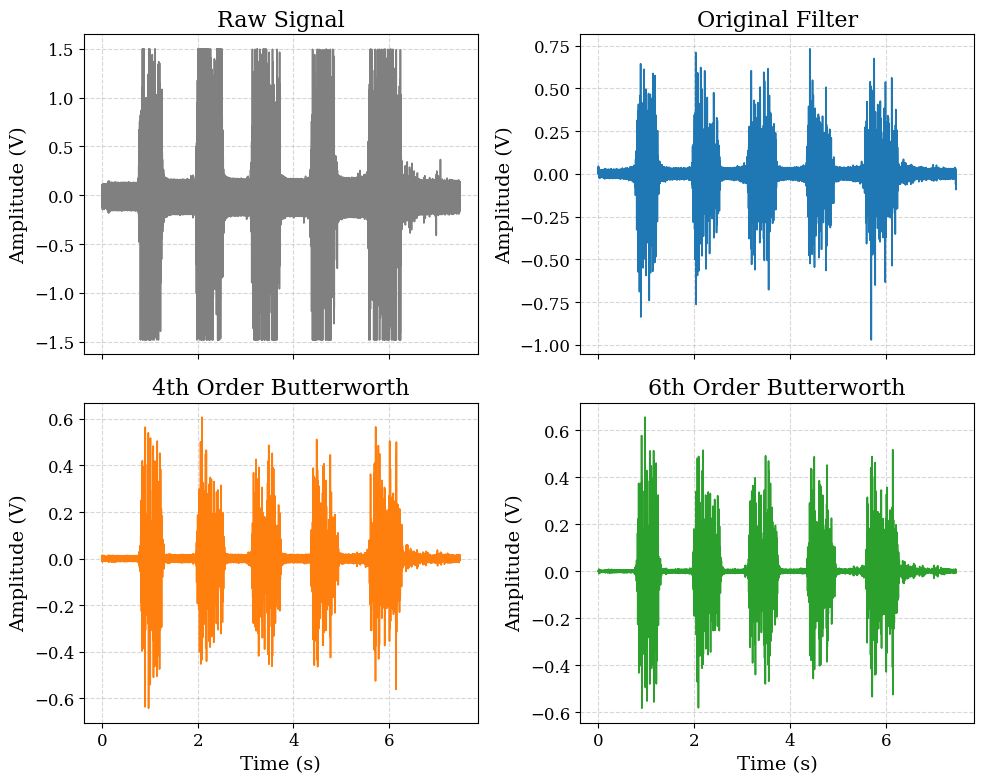

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axs = axs.flatten()

for ax, (label, sig) in zip(axs, signals.items()):
    color = visualization.COLORS.get(label, 'black')
    
    ax.plot(time, sig, label=label, color=color)
    ax.set_title(label)
    ax.set_ylabel("Amplitude (V)")
    ax.grid(True)

axs[2].set_xlabel("Time (s)")
axs[3].set_xlabel("Time (s)")

visualization.save_fig(fig, 'filter_comparison_time.png')
plt.show()

## 4. Power Spectral Density (PSD)
Analyzing frequency content to check for 50Hz noise suppression.

Saved [DRAFT]: ../results/drafts/filter_comparison_psd.png


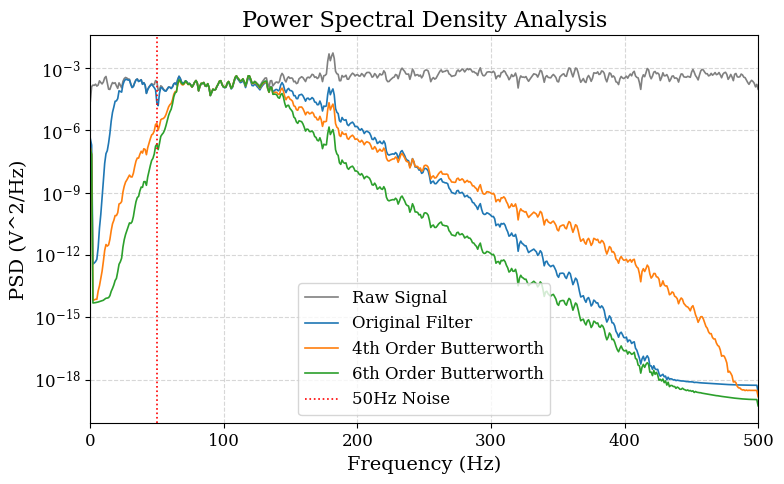

In [9]:
plt.figure(figsize=(8, 5))
for label, sig in signals.items():
    freqs, psd = welch(sig, fs=config.FS, nperseg=1024)
    
    # Explicit color lookup
    color = visualization.COLORS.get(label, 'black')
    plt.semilogy(freqs, psd, label=label, color=color)

plt.axvline(50, color='red', linestyle=':', label='50Hz Noise')
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (V^2/Hz)")
plt.title("Power Spectral Density Analysis")
plt.legend()
plt.xlim(0, 500)

visualization.save_fig(plt.gcf(), 'filter_comparison_psd.png')
plt.show()

## 5. Band Power Distribution
Quantifying energy in the target band (65-135 Hz) versus noise bands.

Saved [DRAFT]: ../results/drafts/filter_power_distribution.png


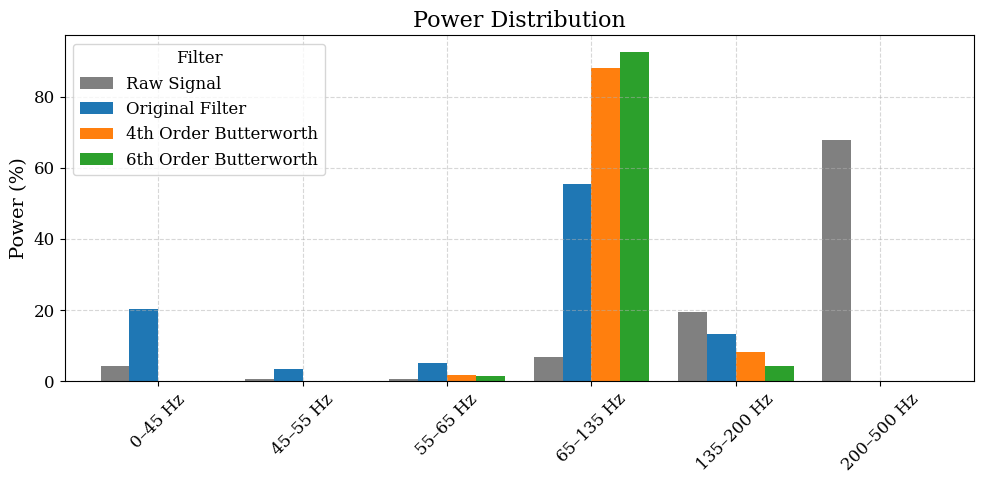

In [10]:
bands = {
    '0–45 Hz': (0, 45), '45–55 Hz': (45, 55), '55–65 Hz': (55, 65),
    '65–135 Hz': (65, 135), '135–200 Hz': (135, 200), '200–500 Hz': (200, 500)
}
results = []
for label, sig in signals.items():
    freqs, psd = welch(sig, fs=config.FS, nperseg=1024)
    total_power = np.trapezoid(psd, freqs)
    row = {'Filter': label}
    for band_name, (low, high) in bands.items():
        idx = (freqs >= low) & (freqs <= high)
        band_power = np.trapezoid(psd[idx], freqs[idx])
        row[band_name] = (band_power / total_power) * 100
    results.append(row)

df = pd.DataFrame(results).set_index('Filter').T

fig, ax = plt.subplots(figsize=(10, 5))
df.plot(kind='bar', ax=ax, width=0.8, color=[visualization.COLORS.get(x, 'k') for x in df.columns])

ax.set_ylabel("Power (%)")
ax.set_title("Power Distribution")
plt.xticks(rotation=45)
visualization.save_fig(plt.gcf(), 'filter_power_distribution.png')
plt.show()